In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
# For date and holidays
from datetime import datetime
import holidays


In [4]:
df = pd.read_csv('StoreDemand.csv')
display(df.head())
display(df.tail())


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [5]:
df.info()
df.describe()
print("Nulls:", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
Nulls: date     0
store    0
item     0
sales    0
dtype: int64


In [12]:
# STEP 4: Feature Engineering
# Convert date
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)


In [14]:
# Add holidays
india_holidays = holidays.country_holidays('IN')
df['holiday'] = df['date'].astype(str).apply(lambda x: 1 if x in india_holidays else 0)


In [15]:
# Cyclical features
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df.head()

,date,store,item,sales,year,month,day,weekday,weekend,holiday,m1,m2
0,2013-01-01,1,1,13,2013,1,1,1,0,0,0.5,0.866025
1,2013-01-02,1,1,11,2013,1,2,2,0,0,0.5,0.866025
2,2013-01-03,1,1,14,2013,1,3,3,0,0,0.5,0.866025
3,2013-01-04,1,1,13,2013,1,4,4,0,0,0.5,0.866025
4,2013-01-05,1,1,10,2013,1,5,5,1,0,0.5,0.866025


In [17]:

df = df.sort_values(by=['store', 'item', 'date'])
df['lag_1'] = df.groupby(['store', 'item'])['sales'].shift(1)
df['rolling_7'] = df.groupby(['store', 'item'])['sales'].shift(1).rolling(7).mean()
df.head()

,date,store,item,sales,year,month,day,weekday,weekend,holiday,m1,m2,lag_1,rolling_7
0,2013-01-01,1,1,13,2013,1,1,1,0,0,0.5,0.866025,NaN,NaN
1,2013-01-02,1,1,11,2013,1,2,2,0,0,0.5,0.866025,13.0,NaN
2,2013-01-03,1,1,14,2013,1,3,3,0,0,0.5,0.866025,11.0,NaN
3,2013-01-04,1,1,13,2013,1,4,4,0,0,0.5,0.866025,14.0,NaN
4,2013-01-05,1,1,10,2013,1,5,5,1,0,0.5,0.866025,13.0,NaN


In [20]:
#drop original date
df.dropna(inplace=True)
df.head()

,date,store,item,sales,year,month,day,weekday,weekend,holiday,m1,m2,lag_1,rolling_7
7,2013-01-08,1,1,9,2013,1,8,1,0,0,0.5,0.866025,10.0,11.857143
8,2013-01-09,1,1,12,2013,1,9,2,0,0,0.5,0.866025,9.0,11.285714
9,2013-01-10,1,1,9,2013,1,10,3,0,0,0.5,0.866025,12.0,11.428571
10,2013-01-11,1,1,9,2013,1,11,4,0,0,0.5,0.866025,9.0,10.714286
11,2013-01-12,1,1,7,2013,1,12,5,1,0,0.5,0.866025,9.0,10.142857


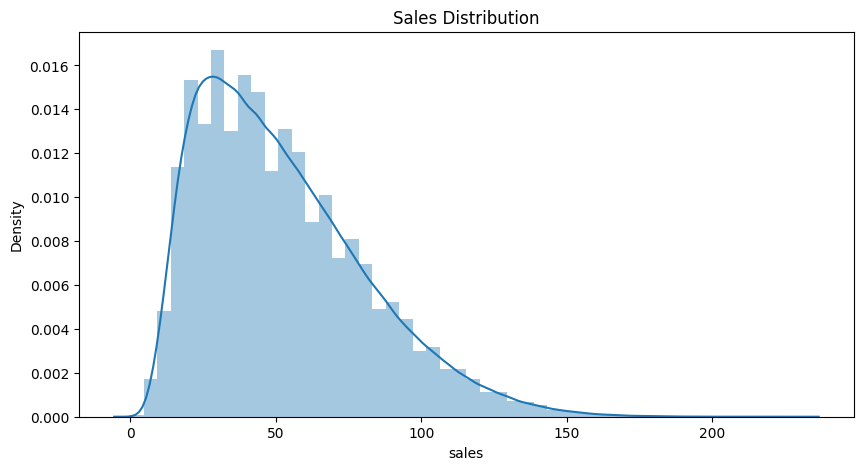

In [21]:
# STEP 5: EDA
plt.figure(figsize=(10, 5))
sb.distplot(df['sales'])
plt.title("Sales Distribution")
plt.show()

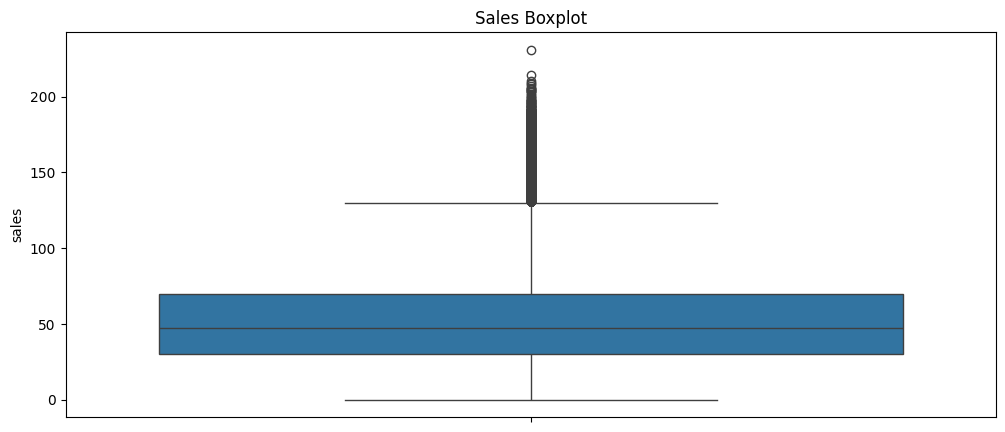

In [22]:
plt.figure(figsize=(12, 5))
sb.boxplot(df['sales'])
plt.title("Sales Boxplot")
plt.show()

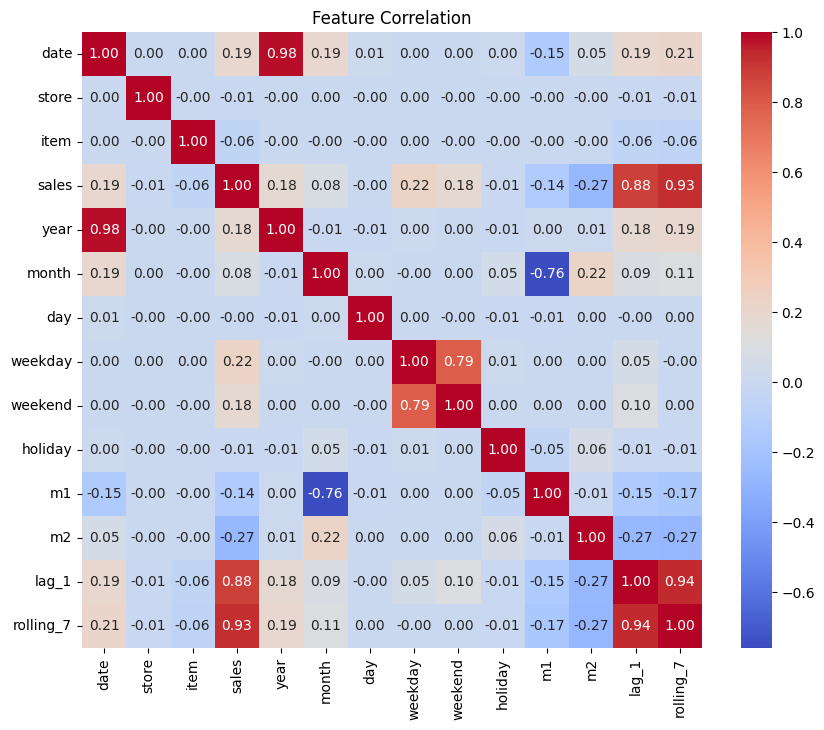

In [23]:
# Correlation
plt.figure(figsize=(10, 8))
sb.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

In [24]:

# STEP 6: Filter Out Outliers
df = df[df['sales'] < 140]

In [25]:
# STEP 7: Train/Test Split (time-based)
train = df[df['date'] < '2017-01-01']
test = df[df['date'] >= '2017-01-01']


In [26]:
X_train = train.drop(['sales', 'date'], axis=1)
y_train = train['sales']
X_test = test.drop(['sales', 'date'], axis=1)
y_test = test['sales']


In [27]:
# STEP 8: Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [28]:
# STEP 9: Model Training
models = [
    ('Linear Regression', LinearRegression()),
    ('Lasso', Lasso()),
    ('Ridge', Ridge()),
    ('XGBoost', XGBRegressor())
]

In [29]:

for name, model in models:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    error = mean_absolute_error(y_test, preds)
    print(f"{name} MAE: {error:.4f}")

Linear Regression MAE: 6.9984
Lasso MAE: 7.0950
Ridge MAE: 6.9984
XGBoost MAE: 6.1660


In [30]:
# STEP 10: Use Best Model (XGBoost assumed)
best_model = XGBRegressor()
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)

In [31]:
# STEP 11: Forecasting Output
test = test.copy()
test['predicted_sales'] = predictions


In [32]:
# Optional: Flag for restocking
def reorder_flag(current_stock, predicted, safety_stock=5):
    return 1 if predicted + safety_stock > current_stock else 0


In [33]:
# For demo, assume constant current_stock
test['current_stock'] = 20
test['reorder'] = test.apply(lambda x: reorder_flag(x['current_stock'], x['predicted_sales']), axis=1)

In [34]:
# View sample results
display(test[['store', 'item', 'predicted_sales', 'current_stock', 'reorder']].head())

,store,item,predicted_sales,current_stock,reorder
1461,1,1,19.898846,20,1
1462,1,1,12.900959,20,0
1463,1,1,15.124473,20,1
1464,1,1,14.852493,20,0
1465,1,1,15.768863,20,1


In [35]:

# Save output
test[['store', 'item', 'date', 'predicted_sales', 'reorder']].to_csv('ForecastedInventory.csv', index=False)